# Infinite patterns by Alexander Mordvintsev


with &nbsp; <img src="https://artsandculture.withgoogle.com/naturalhistorymuseum/images/logo-black.svg" alt="drawing" width="200" style="margin-top:-10px;"/>
<p>&nbsp;</p>

![alt text](https://storage.googleapis.com/cilex-common/temp/infinite-patterns-notebook-imgs/deepdream.png)

Google’s **Alexander Mordvintsev** is the creator of DeepDream, a computer vision program that uses a neural network to find and create patterns in images. The end result often leads to dream-like, hallucinogenic, hyper-processed images.

## Available to everyone

The idea for Infinite Patterns came from a trip to the [Google Arts & Culture Lab](https://experiments.withgoogle.com/collection/arts-culture) in Paris, where [Pinar&Viola](https://www.pinar-viola.com/) saw images created by [DeepDream](https://en.wikipedia.org/wiki/DeepDream) first hand – and noticed similarities between the neural network’s creations and their own body of work. Noticing an opportunity for collaboration, “it felt as if all we have ever done in our career was done to bring us here,” said the artists.

In December 2018, Pinar&Viola joined the lab as artists-in-residence, where they were able to work with Alex in the creation of new work. **Alex created a tool for the artists**, allowing them to create infinite patterns with DeepDream. First, the artists curated a selection of pictures, which were fed into the neural nets tool to extract inspiring patterns. Next, they combined these ML patterns with the original images to create the final design.

**Today, the tool made by Alexander is available for you to use in the creation of your own art works!**

This tools can create a pattern from any picture. More info about how the algorithms works [here](https://distill.pub/2018/differentiable-parameterizations/). 

# Instructions ([video](https://www.youtube.com/watch?v=pFXaE7MLiTU))

1.   Click **CONNECT** in the top right corner

![Connect](https://storage.googleapis.com/cilex-common/temp/infinite-patterns-notebook-imgs/inst2.png)

2. Run the cells by clicking the play button on the top left corner

![Run cell](https://storage.googleapis.com/cilex-common/temp/infinite-patterns-notebook-imgs/run-cell-2.png)

3. Click "<b>download</b>" link in the upper-left corner of the resulting image to save it.

# Upload an image


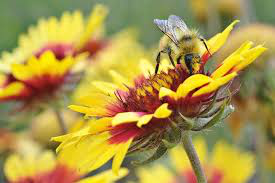

image uploaded, size: (275, 183)

In [6]:
#@title ← Click this button to upload a different image

try:
  import lucid
except ImportError:
  !pip install "lucid>=0.3.11"
  #!pip install --quiet git+https://github.com/tensorflow/lucid.git

from __future__ import print_function
import os
import io
import string
import numpy as np
import PIL
import base64
from glob import glob
import itertools

import cv2

import matplotlib.pylab as pl

import tensorflow as tf
import tf_slim as slim

import IPython
from IPython.display import clear_output, Image, display, HTML

from google.colab import files
from google.colab import output
from google.colab import drive

from lucid.modelzoo import vision_models
import lucid.misc.io.showing as show
from lucid.optvis import objectives
from lucid.optvis import render
from lucid.misc.tfutil import create_session
from lucid.optvis import style
from lucid.modelzoo.util import forget_xy


def imwrite(fn, img):
  if len(img.shape) == 4:
    img = img[0]
  img = np.uint8(img.clip(0, 1)*255)
  im = PIL.Image.fromarray(img)
  im.save(fn, quality=95)

def show_tiled_image(img):
  url = show._image_url(img, fmt='jpeg')
  h, w = img.shape[:2]

  display(HTML('''
  <style>
  #scroll {{
    display: block;
    background: url("{url}") repeat 0 0;
    width: 100%;
    height: {h}px;
    animation: anim 10s linear infinite;
    animation-play-state: paused; 
  }}
  #scroll:hover {{
    animation-play-state: running;
  }}
  @keyframes anim {{
    from {{ background-position: 0 0; }}
    to {{ background-position: -{w}px -{h}px; }}
  }}
  a {{
    background: rgba(255,255,255,.9);
    padding: 5px;
  }}
  
  </style>
  <div id='scroll'><a href="{url}" download='output.jpg'>download</a></div>
  '''.format(url=url, h=h, w=w)))


def anorm(a, axis=None, keepdims=False):
  return (a*a).sum(axis=axis, keepdims=keepdims)**0.5


def composite_activation(x):
  x = tf.atan(x)
  # Coefficients computed by:
  #   def rms(x):
  #     return np.sqrt((x*x).mean())
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   print(rms(a), rms(a*a))
  return tf.concat([x/0.67, (x*x)/0.6], -1)


def composite_activation_unbiased(x):
  x = tf.atan(x)
  # Coefficients computed by:
  #   a = np.arctan(np.random.normal(0.0, 1.0, 10**6))
  #   aa = a*a
  #   print(a.std(), aa.mean(), aa.std())
  return tf.concat([x/0.67, (x*x-0.45)/0.396], -1)


def relu_normalized(x):
  x = tf.nn.relu(x)
  # Coefficients computed by:
  #   a = np.random.normal(0.0, 1.0, 10**6)
  #   a = np.maximum(a, 0.0)
  #   print(a.mean(), a.std())
  return (x-0.40)/0.58


def image_cppn(
    size,
    offset=0.0,
    num_output_channels=3,
    num_hidden_channels=24,
    num_layers=8,
    activation_fn=composite_activation,
    normalize=False):
  coord_range = tf.cast(tf.range(size), tf.float32)/tf.cast(size, tf.float32)*2.0*np.pi
  #coord_range = tf.to_float(tf.range(size))/tf.to_float(size)*2.0*np.pi
  #coord_range = tf.linspace(-np.pi, np.pi, size)
  y, x = tf.meshgrid(coord_range, coord_range, indexing='ij')
  net = tf.expand_dims(tf.stack([x, y], -1), 0)  # add batch dimension
  net += offset
  net = tf.concat([tf.sin(net), tf.cos(net)], -1)
  

  with slim.arg_scope([slim.conv2d], kernel_size=1, activation_fn=None):
    for i in range(num_layers):
      in_n = int(net.shape[-1])
      net = slim.conv2d(
          net, num_hidden_channels,
          # this is untruncated version of tf.variance_scaling_initializer
          weights_initializer=tf.random_normal_initializer(0.0, np.sqrt(1.0/in_n)),
      )
      if normalize:
        net = slim.instance_norm(net)
      net = activation_fn(net)
      
    rgb = slim.conv2d(net, num_output_channels, activation_fn=tf.nn.sigmoid,
                      weights_initializer=tf.zeros_initializer())
  return rgb



def render_graph(fn, size=224, stripe_width=256):
  graph_def = tf.GraphDef.FromString(open(fn, 'rb').read())
  g = tf.Graph()
  with g.as_default():
    tf.import_graph_def(graph_def, name='')
  with tf.compat.v1.Session(graph=g) as sess:
    ty, tx = 'meshgrid/mul:0', 'meshgrid/mul_1:0'
    y, x = sess.run([ty, tx], {'size:0': size})
    stripes = []
    for s in range(0, len(x), stripe_width):
      stripe = sess.run('image:0', {tx: x[s:s+stripe_width], ty: y[s:s+stripe_width]})
      stripes.append(stripe[0])
  return np.vstack(stripes)


model = vision_models.InceptionV1_caffe()
model.load_graphdef()

print('\n↓ Now click the "Choose Files" button and select an image\n')

from google.colab import files
uploaded = files.upload()
image_name, _ = uploaded.popitem()

clear_output()

im = PIL.Image.open(image_name)
g_image = np.float32(im)[...,:3]/255.0

show.image(g_image)

print('\rimage uploaded, size:', im.size, end='')

# Render patterns


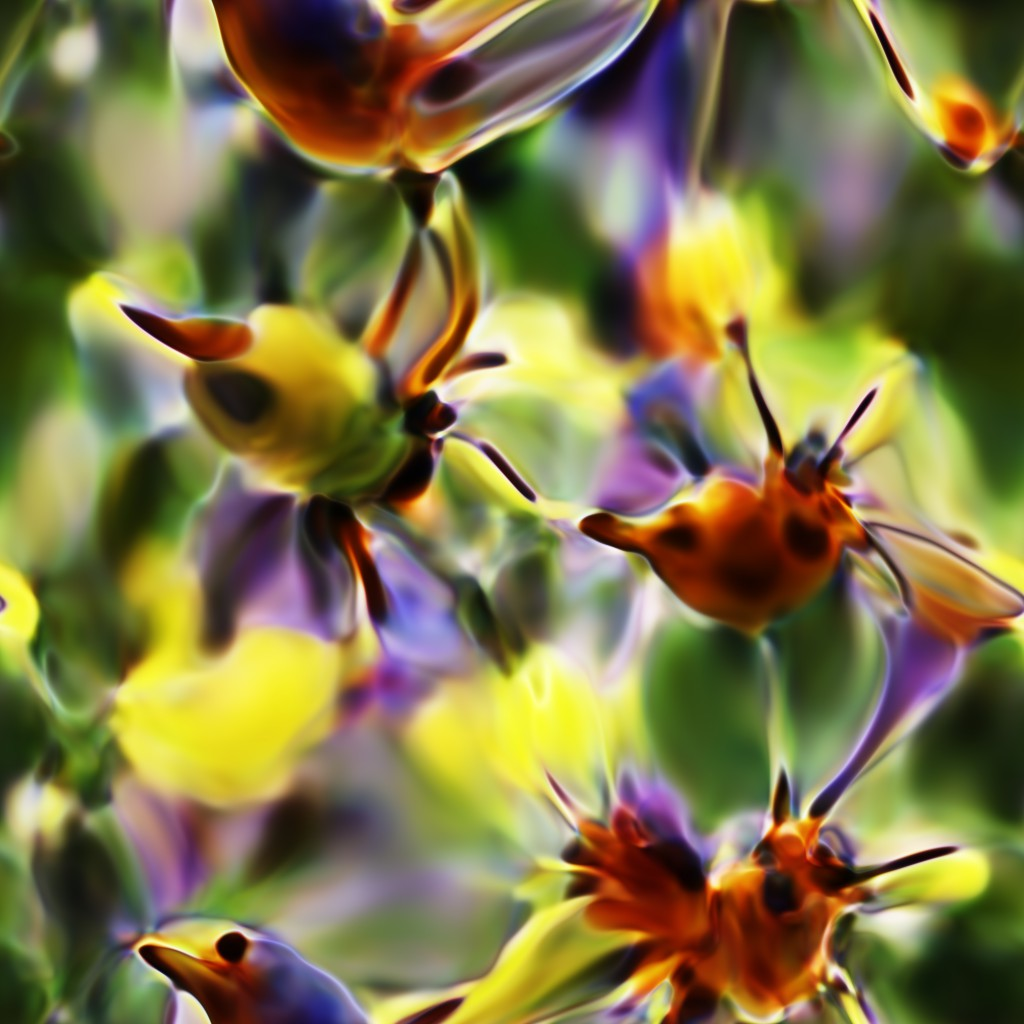
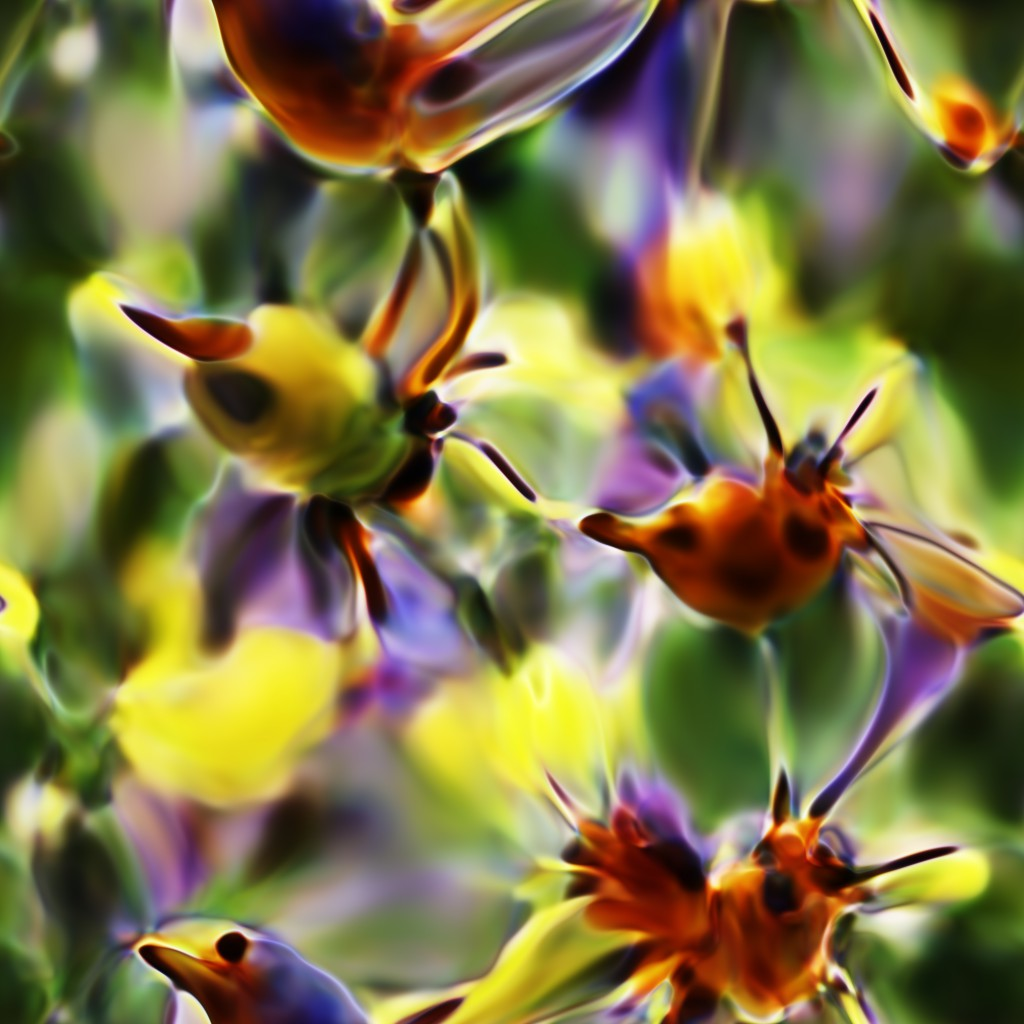

In [7]:
#@title ← Click this button to render
#@markdown # CPPN pattern tool
#@markdown This tool uses simple neural networks that map pixel coordinates to colors to represent image, that gets optimized. This approach is also known as [Compositional pattern-producing network](https://en.wikipedia.org/wiki/Compositional_pattern-producing_network).
#@markdown Optimization tries to generate an image, that produces activation pattern, similar to the target image, in a particular layer (defined by **layer_index**) of ImageNet-trained classification network. **v1** objective tries to match the average pattern, while **v2** tries to match the whole distrubution.
#@markdown **style_weight** parameter defines the contribution of [Gatys et al](https://arxiv.org/abs/1508.06576) style loss, and ignored in case of **v2** objective.
#@markdown **activation** function used in the image-generating CPPN influence the resulting image style.

objective = 'v2' #@param ['v1', 'v2']
activation = 'composite' #@param ['composite', 'relu']
style_weight = 1.34 #@param {type: "slider", min: 0.0, max: 2.0, step:0.01}
layer_index = 7 #@param {type: "slider", min: 2, max: 8}


sess = create_session()

t_size = tf.compat.v1.placeholder_with_default(224, [], name='size')
t_offset = tf.compat.v1.placeholder_with_default([0.0, 0.0], [2], name='offset')
if activation == 'relu':
  t_image = image_cppn(t_size, normalize=True, activation_fn=tf.nn.relu)
elif activation == 'composite':
  t_image = image_cppn(t_size, t_offset, normalize=False, activation_fn=composite_activation_unbiased)
t_image = forget_xy(t_image)
t_image = tf.identity(t_image, 'image')

model.import_graph(t_image)

tensor_name = 'import/%s:0'%model.layers[layer_index].name
tensor = sess.graph.get_tensor_by_name(tensor_name)
act = sess.run(tensor_name, {t_image:g_image[None, :,:,:3]})

if objective=='v2':
  act = act.reshape(-1, act.shape[-1])
  act /= anorm(act, -1, True)

  flat_tensor = tf.reshape(tensor, [-1, act.shape[-1]])
  flat_tensor /= tf.norm(flat_tensor, axis=-1, keepdims=True)

  cross = tf.matmul(flat_tensor, act, transpose_b=True)
  t_loss0 = -tf.reduce_mean(tf.reduce_max(cross, 0))
  t_loss1 = -tf.reduce_mean(tf.reduce_max(cross, 1))
  t_loss = t_loss0 + t_loss1 - tf.reduce_mean(tensor)*0.05
else:
  target_act = act.mean((0, 1, 2))
  t_dd_loss = -tf.reduce_mean(tensor*target_act)
  sl = style.StyleLoss([tensor], loss_func=style.mean_l1_loss)
  t_loss = t_dd_loss + sl.style_loss*style_weight

t_lr = tf.constant(0.003)
trainer = tf.compat.v1.train.AdamOptimizer(t_lr)
train_op = trainer.minimize(t_loss)

init_op = tf.compat.v1.global_variables_initializer()
init_op.run()
if objective=='v1':
  sl.set_style({t_image:g_image[None,...]})

init_op.run()
try:
  for i in range(500+1):
    dx, dy = np.random.rand(2)*np.pi*2
    _, loss = sess.run([train_op, t_loss], {t_offset:[dx, dy]})
    if i%50 == 0:
      clear_output()
      show.image(sess.run(t_image), format='jpeg')
      print(i, loss)
except KeyboardInterrupt:
  pass

clear_output()

img = sess.run(t_image, {t_size:1024})[0]
show_tiled_image(img)



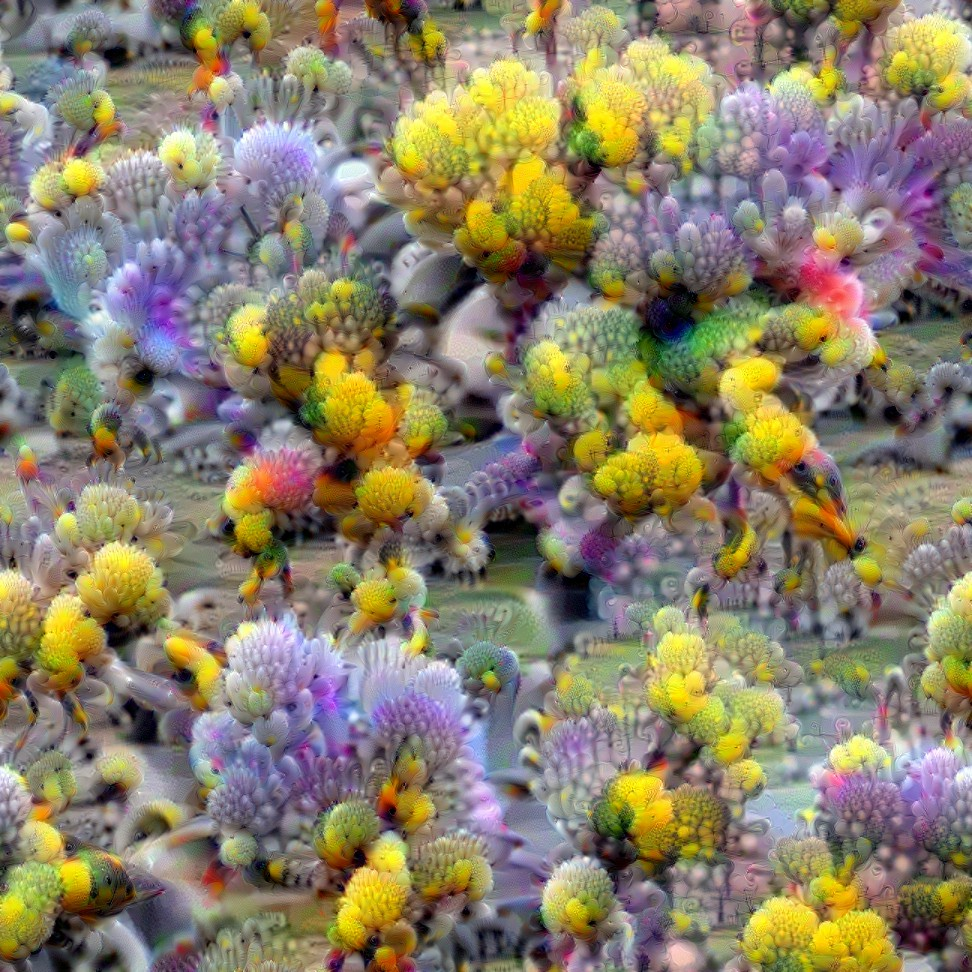
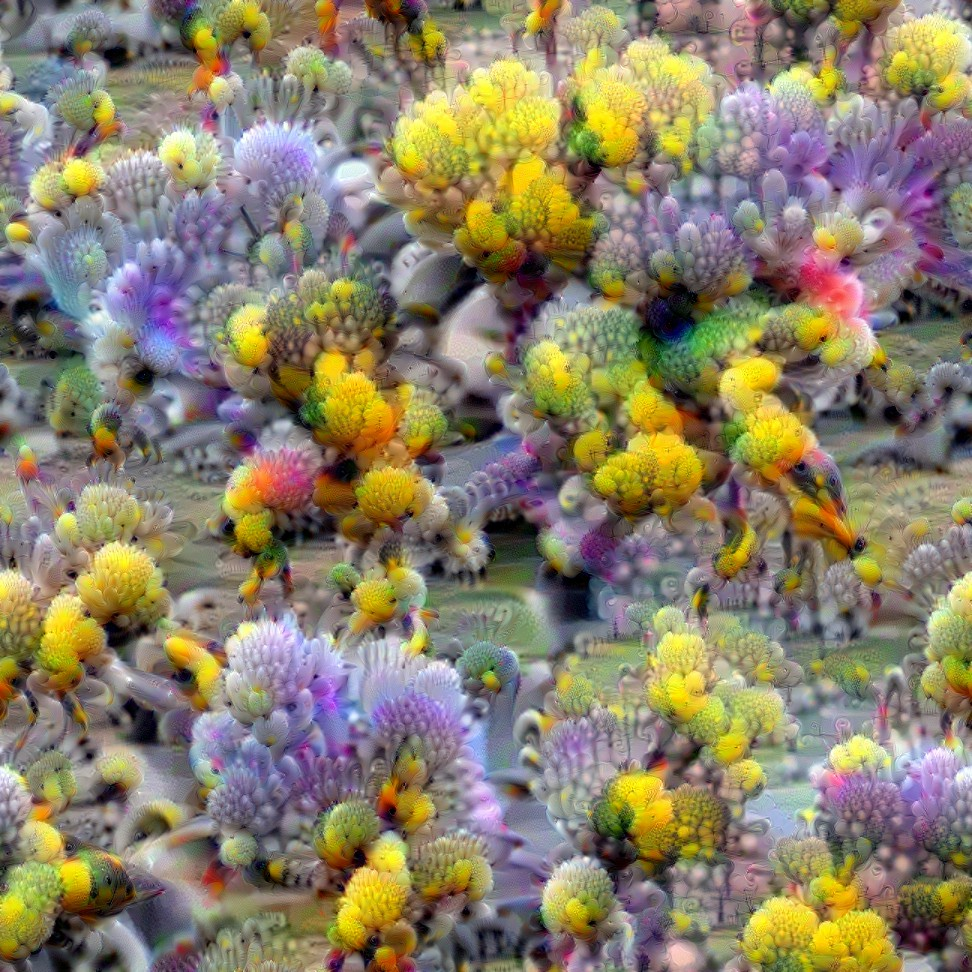

In [8]:
#@title ← Click this button to render
#@markdown # DeepDream pattern tool
#@markdown This tool uses pixel based image representation and a [DeepDream-inspired](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/deepdream) multiscale pattern generation approach.

preview_octave_n = 6
preview_octave_steps = 50

layer_index = 8 #@param {type: "slider", min: 3, max: 8}
selectivity = 2 #@param {type: "slider", min: 0.2, max: 4.0, step: 0.1}
colorful = 0.08 #@param {type: "slider", min: 0.0, max: 0.2, step: 0.01}


k = np.float32([1,4,6,4,1])
k = np.outer(k, k)
k5x5 = k[:,:,None,None]/k.sum()*np.eye(3, dtype=np.float32)


def lap_split(img):
    '''Split the image into lo and hi frequency components'''
    with tf.name_scope('split'):
        lo = tf.nn.conv2d(img, k5x5, [1,2,2,1], 'SAME')
        lo2 = tf.nn.conv2d_transpose(lo, k5x5*4, tf.shape(img), [1,2,2,1])
        hi = img-lo2
    return lo, hi

def lap_split_n(img, n):
    '''Build Laplacian pyramid with n splits'''
    levels = []
    for i in range(n):
        img, hi = lap_split(img)
        levels.append(hi)
    levels.append(img)
    return levels[::-1]

def lap_merge(levels):
    '''Merge Laplacian pyramid'''
    img = levels[0]
    for hi in levels[1:]:
        with tf.name_scope('merge'):
            img = tf.nn.conv2d_transpose(img, k5x5*4, tf.shape(hi), [1,2,2,1]) + hi
    return img

def normalize_std(img, eps=1e-10):
    '''Normalize image by making its standard deviation = 1.0'''
    with tf.name_scope('normalize'):
        std = tf.sqrt(tf.reduce_mean(tf.square(img)))
        return img/tf.maximum(std, eps)

def lap_normalize(img, scale_n=4):
    '''Perform the Laplacian pyramid normalization.'''
    img = tf.expand_dims(img,0)
    tlevels = lap_split_n(img, scale_n)
    tlevels = list(map(normalize_std, tlevels))
    out = lap_merge(tlevels)
    return out[0,:,:,:]

def split1d(n, approx_tile_size):
  tile_n = (n + approx_tile_size//2) // approx_tile_size
  tile_n = max(tile_n, 1)
  tile_size = n // tile_n
  splits = np.arange(tile_n+1)*tile_size
  splits[-1] = n
  return np.c_[splits[:-1], splits[1:]]
  #return list(map(slice, splits[:-1], splits[1:]))

def split2d(shape, approx_tile_size):
  h, w = shape
  splity = split1d(h, approx_tile_size)
  splitx = split1d(w, approx_tile_size)
  splits = itertools.product(splity, splitx)
  tiles = list(splits)
  return tiles


def show_crop(dream, sz=512):
  y, x = np.int32(dream.rgb.shape[:2]) // 2 - sz//2
  rgb = dream.rgb[y:y+sz, x:x+sz]
  show.image(rgb, format='jpeg')
  
class DeepDream:
  
  def __init__(self, g_image, params, shape0=(128, 128)):
    self.params = params
    self.octave_scale = 1.5
    self.base_step = 0.02
    h, w = np.int32(shape0)
    self.rgb = np.float16(np.random.rand(h, w, 3)*0.01+0.5)
    
    layer_index = params['layer_index']
    graph = tf.Graph()
    sess = self.sess = tf.compat.v1.Session(graph=graph)
    with sess.as_default(), graph.as_default():
      self.t_rgb = tf.compat.v1.placeholder(tf.float32, [None, None, 3])
      model.import_graph(self.t_rgb)
      tensor = sess.graph.get_tensor_by_name("import/%s:0"%model.layers[layer_index].name)
      
      act = sess.run(tensor, {self.t_rgb:g_image})
      act **= params['selectivity']
      target_act = act.mean((0, 1, 2))
      target_act /= target_act.max()
      t_dd_loss = -tf.reduce_mean(tensor*target_act)
      t_loss = t_dd_loss
      t_score = -t_loss
      
      [t_rgb_grad] = tf.gradients(t_score, self.t_rgb)
      self.t_rgb_grad = lap_normalize(t_rgb_grad, 4)
    
     
  def run_octave(self, iter_n, step, iter_cb=None):
    h, w = np.int32(self.rgb.shape[:2])
    tiles = split2d((h, w), 768)
    for i in range(iter_n):
      x, y = np.random.randint(256, size=2)
      self.rgb[:] = np.roll(np.roll(self.rgb, x, 1), y, 0)
      for ry, rx in tiles:
        self.run_tile(rx, ry, step)
      self.rgb[:] = np.roll(np.roll(self.rgb,-x, 1),-y, 0)
      if iter_cb:
        iter_cb(self.rgb)
      print('\r', end='')
      print(i, end='', flush=True)
    print('\r', end='')
    
  def run_tile(self, range_x, range_y, step):
    M = np.float32([[ 0.07911157, 0.06922007, 0.0629285 ],
                    [ 0.06922007, 0.07536791, 0.07108173],
                    [ 0.0629285, 0.07108173, 0.08204902]])
    tile = slice(*range_y), slice(*range_x)
    rgb = self.rgb[tile]
    g_rgb = self.sess.run(self.t_rgb_grad, {self.t_rgb: rgb})
    g_rgb = g_rgb.dot(M+np.eye(3)*self.params['colorful'])
    g_rgb *= step / (g_rgb.std()+1e-5)
    rgb += g_rgb
    rgb[:] = np.clip(rgb, 0.0, 1.0)
    
  def upscale_image(self, img):
    scale = self.octave_scale
    img = cv2.resize(np.float32(img), None, None, scale, scale)
    return np.float16(img)
      
  def upscale(self, gamma=2.2):
    if gamma != 1.0:
      self.rgb **= 1.0/gamma
    self.rgb = self.upscale_image(self.rgb)
    if gamma != 1.0:
      self.rgb **= gamma
         
  def run(self, octave, iter_n, iter_cb=None):
    if octave > 0:
      self.upscale()
    step_reduction = max(0.2, self.octave_scale**(-octave))
    octave_step = self.base_step * step_reduction
    self.run_octave(iter_n, octave_step, iter_cb)
    print(octave, self.rgb.shape, octave_step)


frames = []

params = dict(
    layer_index=layer_index,
    selectivity=selectivity,
    colorful=colorful
)
dream = DeepDream(g_image, params)
try:
  for octave in range(preview_octave_n):
    clear_output()
    show.image(dream.rgb, format='jpeg')
    dream.run(octave, preview_octave_steps, iter_cb=lambda a: frames.append(a.copy()))
except KeyboardInterrupt:
  pass
finally:
  clear_output()
  show_tiled_image(dream.rgb)